In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
from tqdm import tqdm_notebook
import datetime
import gc
from itertools import cycle, islice
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit
import multiprocessing
import warnings
import datetime
from sklearn.preprocessing import LabelEncoder

In [74]:
sns.set()
%matplotlib inline

In [75]:
warnings.simplefilter('ignore')
files = ['./input/test_identity.csv', 
         './input/test_transaction.csv',
         './input/train_identity.csv',
         './input/train_transaction.csv',
         './input/sample_submission.csv']

In [76]:
#可以对数据进行压缩，从而减少内存消耗
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def load_data(file):
    return reduce_mem_usage(pd.read_csv(file))

In [198]:
%%time
# 线程池读取多个数据集
with multiprocessing.Pool() as pool:
    test_identity, test_transaction, train_identity, train_transaction, sample_submission = pool.map(load_data,files)

Mem. usage decreased to  2.90 Mb (62.5% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
CPU times: user 1.36 s, sys: 2.34 s, total: 3.7 s
Wall time: 2min 37s


In [90]:
#各个数据集缺失情况
print ("% of train_transaction data missing = ",(train_transaction[train_transaction.columns].isnull().sum().sum()/np.product(train_transaction.shape)) * 100)
print ("% of train_identity data missing = ",(train_identity[train_identity.columns].isnull().sum().sum()/np.product(train_identity.shape)) * 100)
print ("% of test_transaction data missing = ",(test_transaction[test_transaction.columns].isnull().sum().sum()/np.product(test_transaction.shape)) * 100)
print ("% of test_identity data missing = ",(test_identity[test_identity.columns].isnull().sum().sum()/np.product(test_identity.shape)) * 100)

% of train_transaction data missing =  41.073431200111266
% of train_identity data missing =  35.58109650830896
% of test_transaction data missing =  36.90570194240822
% of test_identity data missing =  36.18627245910109


In [199]:
#现对train-test-identy处理设备特征
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]
    
    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [200]:
train_identity = id_split(train_identity)
test_identity = id_split(test_identity)

In [201]:
#合并数据
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
del test_identity, test_transaction, train_identity, train_transaction
#垃圾回收机制
gc.collect()

42

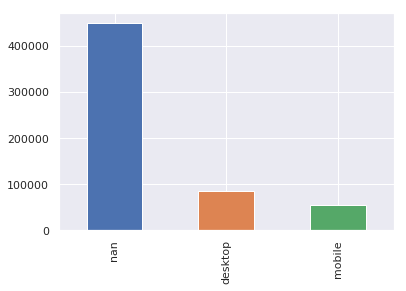

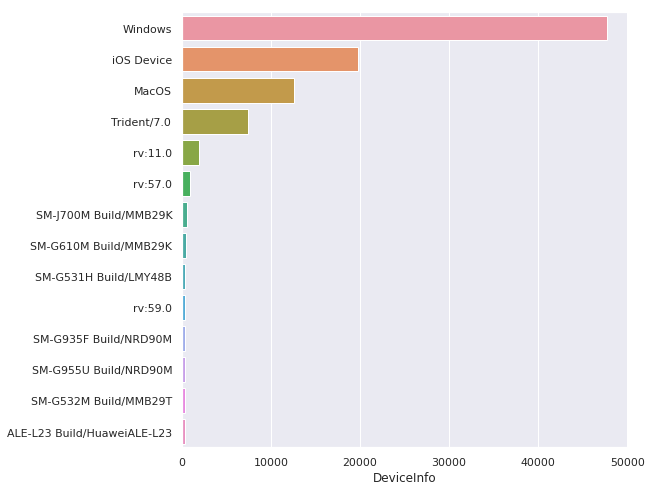

In [202]:
# 查看分布
train["DeviceType"].value_counts(dropna=False).plot.bar()
plt.show()
plt.figure(figsize=(8, 8))
sns.barplot(train["DeviceInfo"].value_counts(dropna=False)[:15],
            train["DeviceInfo"].value_counts(dropna=False).keys()[:15])
plt.show()

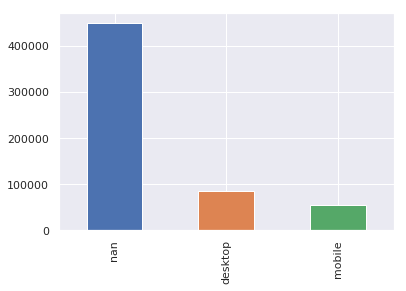

In [203]:
train["DeviceType"].value_counts(dropna=False).plot.bar()
plt.show()

In [204]:
#转化成时间格式
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')

train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
#处理TransactionDT特征 生成衍生变量  ***一天中的时间对欺诈比较有用？  以2019.01.01 0:0:0开始？
train['DT_M'] = (train['TransactionDT'].dt.year-2017)*12 + train['TransactionDT'].dt.month
train['DT_W'] = (train['TransactionDT'].dt.year-2017)*52 + train['TransactionDT'].dt.weekofyear
train['DT_D'] = (train['TransactionDT'].dt.year-2017)*365 + train['TransactionDT'].dt.dayofyear
train['DT_hour'] = train['TransactionDT'].dt.hour
train['DT_day_week'] = train['TransactionDT'].dt.dayofweek
train['DT_day'] = train['TransactionDT'].dt.day

test['DT_M'] = (test['TransactionDT'].dt.year-2017)*12 + test['TransactionDT'].dt.month
test['DT_W'] = (test['TransactionDT'].dt.year-2017)*52 + test['TransactionDT'].dt.weekofyear
test['DT_D'] = (test['TransactionDT'].dt.year-2017)*365 + test['TransactionDT'].dt.dayofyear
test['DT_hour'] = test['TransactionDT'].dt.hour
test['DT_day_week'] = test['TransactionDT'].dt.dayofweek
test['DT_day'] = test['TransactionDT'].dt.day

In [205]:
# 邮箱处理
train['is_proton_mail'] = (train['P_emaildomain'] == 'protonmail.com') | (train['R_emaildomain'] == 'protonmail.com')
test['is_proton_mail'] = (test['P_emaildomain'] == 'protonmail.com') | (test['R_emaildomain'] == 'protonmail.com')
train['is_mail'] = (train['P_emaildomain'] == 'mail.com') | (train['R_emaildomain'] == 'mail.com')
test['is_mail'] = (test['P_emaildomain'] == 'mail.com') | (test['R_emaildomain'] == 'mail.com')

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other',
          'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol',
          'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other',
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft',
          'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft',
          'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    # 公司 google
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    # 组织 com
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])

    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
print('email_process_done')

email_process_done


In [206]:
a = np.zeros(train.shape[0])
train["lastest_browser"] = a
a = np.zeros(test.shape[0])
test["lastest_browser"] = a
def setbrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df
train=setbrowser(train)
test=setbrowser(test)

In [207]:
#特征工程
#第一步删除两个数据集中超过0.9的空值特征
train_missing_values = train.isnull().sum().sort_values(ascending=False) / len(train)
test_missing_values = test.isnull().sum().sort_values(ascending=False) / len(test)

train_missing_values = [str(x) for x in train_missing_values[train_missing_values > 0.90].keys()]
test_missing_values = [str(x) for x in test_missing_values[test_missing_values > 0.90].keys()]

dropped_columns = train_missing_values + test_missing_values
# 第二步删除特征分布不均匀的情况二  即特征值超过0.9都是同一个值     但是isFraud也属于这种情况要去除掉
dropped_columns = dropped_columns + [col for col in train.columns if
                                     train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
dropped_columns = dropped_columns + [col for col in test.columns if
                                     test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
dropped_columns.remove('isFraud')
# 删除不符合的特征
train.drop(dropped_columns, axis=1, inplace=True)
test.drop(dropped_columns, axis=1, inplace=True)
print(len(dropped_columns))

177


In [208]:
# 增加一些有利于分类的衍生特征
train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

In [209]:
# Let's add some kind of client uID based on cardID ad addr columns
train['uid'] = train['card1'].astype(str) + '_' + train['card2'].astype(str)
test['uid'] = test['card1'].astype(str) + '_' + test['card2'].astype(str)

train['uid2'] = train['uid'].astype(str) + '_' + train['card3'].astype(str) + '_' + train['card5'].astype(str)
test['uid2'] = test['uid'].astype(str) + '_' + test['card3'].astype(str) + '_' + test['card5'].astype(str)

train['uid3'] = train['uid2'].astype(str) + '_' + train['addr1'].astype(str) + '_' + train['addr2'].astype(str)
test['uid3'] = test['uid2'].astype(str) + '_' + test['addr1'].astype(str) + '_' + test['addr2'].astype(str)

In [210]:
# Check if the Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with a model we are telling to trust or not to these values 
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check'] = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)
# New feature - decimal part of the transaction amount 小数点代表不同区域
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(
    int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)
#其他衍生变量
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])[ 'TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])[ 'TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform( 'mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['TransactionAmt_to_mean_card2'] = train['TransactionAmt'] / train.groupby(['card2'])[ 'TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card3'] = train['TransactionAmt'] / train.groupby(['card3'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card2'] = train['TransactionAmt'] / train.groupby(['card2'])[ 'TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card3'] = train['TransactionAmt'] / train.groupby(['card3'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_mean_card5'] = train['TransactionAmt'] / train.groupby(['card5'])[ 'TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card5'] = train['TransactionAmt'] / train.groupby(['card5'])[ 'TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card2'] = test['TransactionAmt'] / test.groupby(['card2'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card3'] = test['TransactionAmt'] / test.groupby(['card3'])['TransactionAmt'].transform( 'mean')
test['TransactionAmt_to_std_card2'] = test['TransactionAmt'] / test.groupby(['card2'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card3'] = test['TransactionAmt'] / test.groupby(['card3'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_mean_card5'] = test['TransactionAmt'] / test.groupby(['card5'])['TransactionAmt'].transform( 'mean')
test['TransactionAmt_to_std_card5'] = test['TransactionAmt'] / test.groupby(['card5'])['TransactionAmt'].transform('std')
#二次衍生变量
train['TransactionAmt_to_mean_uid'] = train['TransactionAmt'] / train.groupby(['uid'])[ 'TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_uid2'] = train['TransactionAmt'] / train.groupby(['uid2'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_uid3'] = train['TransactionAmt'] / train.groupby(['uid3'])[ 'TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_uid'] = train['TransactionAmt'] / train.groupby(['uid'])[ 'TransactionAmt'].transform('std')
train['TransactionAmt_to_std_uid2'] = train['TransactionAmt'] / train.groupby(['uid2'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_uid3'] = train['TransactionAmt'] / train.groupby(['uid3'])[ 'TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_uid'] = test['TransactionAmt'] / test.groupby(['uid'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_uid2'] = test['TransactionAmt'] / test.groupby(['uid2'])['TransactionAmt'].transform( 'mean')
test['TransactionAmt_to_mean_uid3'] = test['TransactionAmt'] / test.groupby(['uid3'])['TransactionAmt'].transform( 'mean')
test['TransactionAmt_to_std_uid'] = test['TransactionAmt'] / test.groupby(['uid'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_uid2'] = test['TransactionAmt'] / test.groupby(['uid2'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_uid3'] = test['TransactionAmt'] / test.groupby(['uid3'])['TransactionAmt'].transform('std')

#最后转化成log值
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [211]:
########################### M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train, test]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [212]:
#变量用count做衍生  计数编码
#card1的 #变量用count做衍生  计数编码
train['card1_count_full'] = train['card1'].map(
    pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(
    pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

for feature in ['card2', 'card3', 'card4', 'card5', 'card6', 'id_34', 'id_36']:
    train[feature + '_count_full'] = train[feature].map(
        pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(
        pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

for feature in ['id_01', 'id_31', 'id_33', 'id_35','id_34', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))
########################### Reset values for "noise" card1
for col in ['card1']:
    valid_card = pd.concat([train[[col]], test[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card > 2]
    valid_card = list(valid_card.index)

    train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
    test[col] = np.where(test[col].isin(train[col]), test[col], np.nan)

    train[col] = np.where(train[col].isin(valid_card), train[col], np.nan)
    test[col] = np.where(test[col].isin(valid_card), test[col], np.nan)

In [213]:
# 填充掉空值 
numerical_columns = list(test.select_dtypes(exclude=['object']).columns)
train[numerical_columns] = train[numerical_columns].fillna(train[numerical_columns].median())
test[numerical_columns] = test[numerical_columns].fillna(train[numerical_columns].median())
print("filling numerical columns null values done")

# Now, we find out categorical columns
categorical_columns = list(filter(lambda x: x not in numerical_columns, list(test.columns)))
categorical_columns[:5]

filling numerical columns null values done


['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']

In [214]:
# then, fill missing values in categorical columns
train[categorical_columns] = train[categorical_columns].fillna(train[categorical_columns].mode())
test[categorical_columns] = test[categorical_columns].fillna(train[categorical_columns].mode())
print("filling categorica columns null values done")

filling categorica columns null values done


In [215]:
# Label Encoding 转化X_train[f].dtype=='object'的列
#标准化标签，将标签值统一转换成range(标签值个数-1)范围        
for col in tqdm_notebook(categorical_columns):
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))

# Because of using cross validation, we use this step later when we want to find best model. Now, we have to remove isFraud column from daraframe
labels = train["isFraud"]
train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1, inplace=True)
test.drop(['TransactionDT', 'TransactionID'], axis=1,inplace=True)

In [216]:
X_train, y_train = train, labels
del train, labels
gc.collect()

35

In [217]:
params = {
    'learning_rate': 0.01,#0.05
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 380,#150 小于2的max_depth次方
    'min_data_in_leaf': 106,
    'verbose': -1,
    'max_depth': 9,
    'lambda_l2': 5, 'lambda_l1': 0,
    'nthread': -1,
    'seed': 89,
    #0903添加的
    #'n_estimators':200, ####加这个估计器数目 准确度就下来了
#     'tree_method': 'gpu_hist',
#     'device': 'gpu', ##如果安装的事gpu版本的lightgbm,可以加快运算
#     'gpu_platform_id': 1,# Intel，Nvidia，AMD
#     'gpu_device_id': 0
}

In [218]:
#五折交叉验证
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)

    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.990783	valid_1's auc: 0.899385
Early stopping, best iteration is:
[1274]	training's auc: 0.995324	valid_1's auc: 0.900501
Fold 1 finished in 0:00:55.146830
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.981577	valid_1's auc: 0.91701
[2000]	training's auc: 0.99529	valid_1's auc: 0.919473
Early stopping, best iteration is:
[1802]	training's auc: 0.99395	valid_1's auc: 0.919808
Fold 2 finished in 0:01:58.405035
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.976435	valid_1's auc: 0.907132
[2000]	training's auc: 0.991725	valid_1's auc: 0.911786
Early stopping, best iteration is:
[2290]	training's auc: 0.993879	valid_1's auc: 0.912155
Fold 3 finished in 0:05:52.938995
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's au

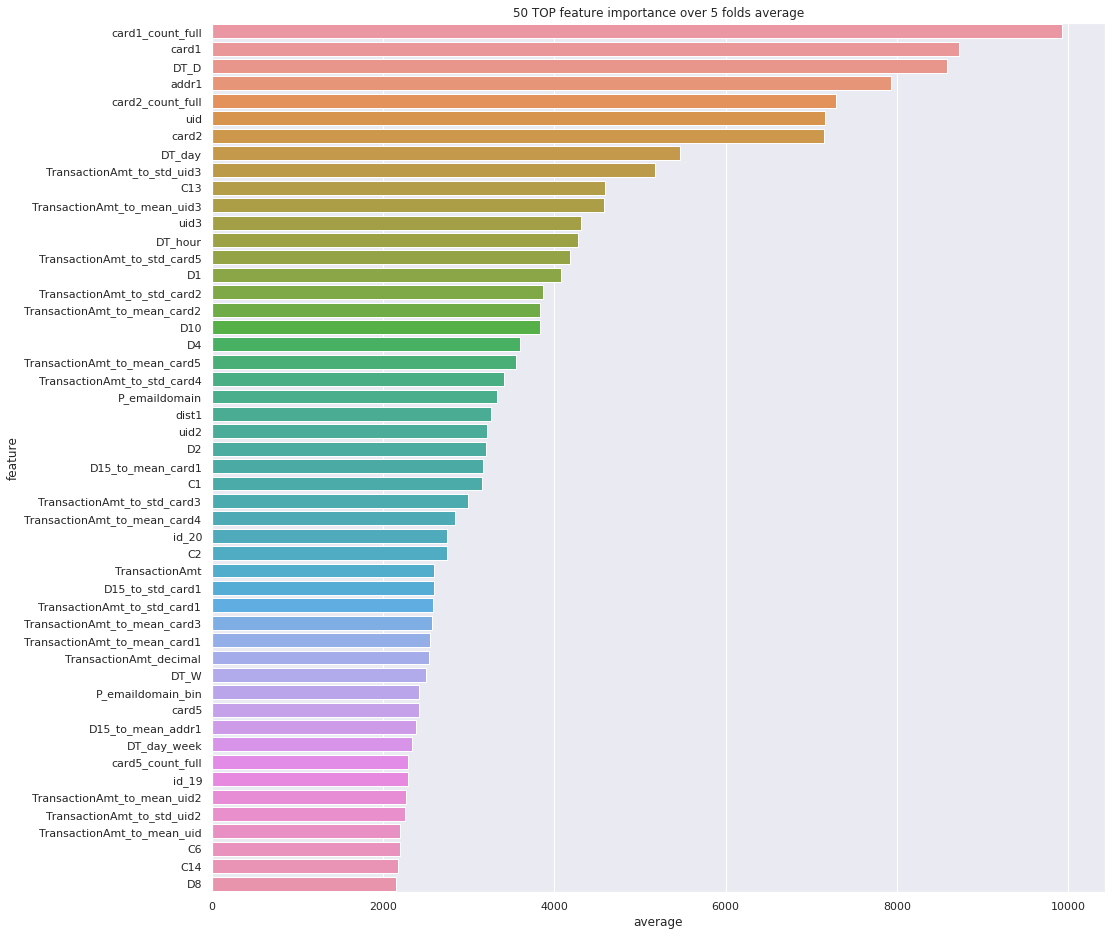

In [219]:
#获取重要特征-----------------------------------------------------------------------------------------------------------
feature_importances['average'] = feature_importances[
    ['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [157]:
#predict = clf.predict(test)
#sample_submission['isFraud']=list(predict)

In [220]:
best_iter = clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=2, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
        importance_type='split', lambda_l1=0, lambda_l2=5,
        learning_rate=0.01, max_depth=9, metric='auc',
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=106,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, nthread=-1,
        num_boost_round=4053, num_leaves=380, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=89,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0, verbose=-1)

In [176]:
X_train.shape, test.shape

((590540, 408), (506691, 408))

In [221]:
sample_submission['isFraud'] = clf.predict_proba(test)[:, 1]

In [222]:
sample_submission.head(3)

,TransactionID,isFraud
0,3663549,0.000490
1,3663550,0.001197
2,3663551,0.001043


In [179]:
len(sample_submission)

506691

In [223]:
sample_submission.to_csv('./output/aaa117.csv', index=False)